# <center>Using DeepIRTools</center>

## Pre-Processing

In [2]:
import os
import numpy as np
import torch
import deepirtools
from deepirtools import IWAVE
from factor_analyzer import Rotator
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
plt.rcParams['figure.figsize'] = (9, 6)
deepirtools.manual_seed(123) # Seed for reproducibility.

In [3]:
group = 1           # age class 'AK'
test_size = 0.2     # train-test split
sub = False         # subjective meassures
save_dir = './paper_models_test'

dat = pd.read_csv('../data/merged_male.csv')

y_0 = dat['LZ']
dat = dat.drop(['TalentID', 'AK', 'LZ'], axis=1).reset_index(drop=True)
X_0 = dat.iloc[:,:]
# dat0 = pd.read_csv('data/dat_vs1', sep=' ', index_col=False)
# dat = dat0[dat0['AK'] == group]
# dat = dat.drop('AK', axis=1).reset_index(drop=True)
# if sub:
#     c = 16
# else:
#     c = 14
# # english variable-names
X_names = ['relative age', 'height', 'weight', 'sprint (20m)', 'agility','dribbling','ball control','juggling','tactical skills','kicking skills','endurance','psychological skills']
# X_0 = dat.iloc[:, 2:c]
# y_0 = dat.iloc[:, 16]
X_0.columns = X_names


X, X_test, y, y_test = train_test_split(X_0, y_0, test_size=test_size, random_state=42, stratify=y_0)
X.columns = X_names




# ___ SCALING
# MinMax [0,1]
#scaler_train = StandardScaler().fit(X)
#df_train = scaler_train.transform(X)
#y_train = np.asarray(y)
#df_test = scaler_train.transform(X_test)

# torch
#dft = torch.tensor(df_train)
#dftest = torch.tensor(df_test)
#sample_size = df_train.shape[0]
#test_size = df_test.shape[0]
#Y = dft.view(sample_size, -1)
#Ytest = dftest.view(test_size, -1)

# Full data
X_full = X_0.copy()
y_full = y_0.copy()

scaler = StandardScaler().fit(X)
df = scaler.transform(X)
y = np.asarray(y_full)

dft = torch.tensor(df)
sample_size = df.shape[0]
Y = dft.view(sample_size, -1)
n_items = Y.shape[1]

In [61]:
# Save training data with labels
train_data = X.copy()
train_data['y'] = y_full.loc[X.index].values
train_data.to_csv('../data/train.csv', index=False)

# Save test data with labels
test_data = X_test.copy()
test_data['y'] = y_test.values
test_data.to_csv('../data/test.csv', index=False)

## Learn and safe one model

In [5]:
# IWAVE
model_name = 'train_iwave'
load_model = os.path.exists(save_dir + '/' + model_name + '.pth')

# specs
latent_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ref_idxs = [1,3,6,8]
A = torch.ones(latent_size * n_items)
b = torch.zeros(latent_size * n_items)
for factor_idx in range(latent_size):
    ref_idx = ref_idxs[factor_idx]
    A[n_items * factor_idx + ref_idx] = 0
    b[n_items * factor_idx + ref_idx] = 1 # Fix anchor item's loading on one factor to one.
A = A.diag()
ints_mask = torch.zeros(n_items)
inf_net = [15,8]

# model
iwave = IWAVE(model_type = "normal",
              learning_rate = 5e-4 if device=="cpu" else 1e-3,
              gradient_estimator='dreg',
              n_intervals = 100,
              device = device,
              A = A,
              b = b,
              ints_mask = ints_mask,
              inference_net_sizes = inf_net,
              latent_size = latent_size,
              n_items = n_items,
              fixed_variances = False,
              fixed_means = False,
              use_spline_prior = False,
              log_interval = 25,
              )
if load_model:
    iwave.load_model(model_name, save_dir)
else:
    iwave.fit(Y, batch_size = 128 if device=="cpu" else 1024) # Bigger batches on GPU.
    iwave.save_model(model_name, save_dir)


Initializing model parameters
Initialization ended in  0.0  seconds


In [6]:
# nIWAVE
model_name = 'train_niwave'
load_model = os.path.exists(save_dir + '/' + model_name + '.pth')

# specs
latent_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ref_idxs = [1,3,6,8]
A = torch.ones(latent_size * n_items)
b = torch.zeros(latent_size * n_items)
for factor_idx in range(latent_size):
    ref_idx = ref_idxs[factor_idx]
    A[n_items * factor_idx + ref_idx] = 0
    b[n_items * factor_idx + ref_idx] = 1 # Fix anchor item's loading on one factor to one.
A = A.diag()
ints_mask = torch.zeros(n_items)
inf_net = [15,8]

# model
niwave = IWAVE(model_type = "normal",
               learning_rate = 5e-4 if device=="cpu" else 1e-3,
               # batch size on GPU.
               gradient_estimator='dreg',
               n_intervals = 100,
               device = device,
               A = A,
               b = b,
               ints_mask = ints_mask,
               inference_net_sizes = inf_net,
               latent_size = latent_size,
               n_items = n_items,
               fixed_variances = False,
               fixed_means = False,
               use_spline_prior = True,
               count_bins = 32,
               flow_length = 2,
               log_interval = 25,
               )
if load_model:
    niwave.load_model(model_name, save_dir)
else:
    niwave.fit(Y, batch_size = 128 if device=="cpu" else 1024) # Bigger batches on GPU.
    niwave.save_model(model_name, save_dir)


Initializing model parameters
Initialization ended in  30.16  seconds


In [ ]:
latent_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#ref_idxs = Y.var(dim = 0).sort(descending = True)[1][:latent_size] # Find anchor items.
ref_idxs = [1,3,6,8]
A = torch.ones(latent_size * n_items)
b = torch.zeros(latent_size * n_items)
for factor_idx in range(latent_size):
    ref_idx = ref_idxs[factor_idx]
    A[n_items * factor_idx + ref_idx] = 0
    b[n_items * factor_idx + ref_idx] = 1 # Fix anchor item's loading on one factor to one.
A = A.diag()
ints_mask = torch.zeros(n_items)

model_name = 'train_iwave'
inf_net = [15,8]

train_iwave = IWAVE(model_type = "normal",
              learning_rate = 5e-4 if device=="cpu" else 1e-3, # Bigger learning rate with increased
              # batch size on GPU.
              gradient_estimator='dreg',
              n_intervals = 100,
              device = device,
              A = A,
              b = b,
              ints_mask = ints_mask,
              inference_net_sizes = inf_net,
              latent_size = latent_size,
              n_items = n_items,
              fixed_variances = False,
              fixed_means = False,
              use_spline_prior = False,
              log_interval = 25,
              )

train_iwave.load_model(model_name, "./saved_models")

In [6]:
#### Load second model
model_name = 'train_niwave'
inf_net = [15,8]

train_niwave = IWAVE(model_type = "normal",
              learning_rate = 5e-4 if device=="cpu" else 1e-3, # Bigger learning rate with increased
              gradient_estimator='dreg',
              n_intervals = 100,
              device = device,
              A = A,
              b = b,
              ints_mask = ints_mask,
              inference_net_sizes = inf_net,
              latent_size = latent_size,
              n_items = n_items,
              fixed_variances = False,
              fixed_means = False,
              use_spline_prior = True,
              count_bins = 32,
              flow_length = 2,
              log_interval = 25,
              )

train_niwave.load_model(model_name, "./saved_models")


Initializing model parameters
Initialization ended in  19.07  seconds


## Log-likelihood

In [8]:
#Xt_test = torch.tensor(df_test)
#test_size = Xt_test.shape[0]
#Y_test = Xt_test.view(test_size, -1)

ll = iwave.log_likelihood(data = Y, iw_samples = 5000)
nll = niwave.log_likelihood(data = Y, iw_samples = 5000) # Increasing iw_samples
print(-ll/sample_size,-nll/sample_size)


Computing approx. LL
Approx. LL computed in 20.39 seconds

Computing approx. LL
Approx. LL computed in 284.96 seconds
14.860972201635361 12.138074281698845


## Rotation

### IWAVE

In [9]:

loadings_iwave = np.asarray(iwave.loadings)

rotator = Rotator(method = "geomin_obl")
rot_loadings_iwave = torch.from_numpy(rotator.fit_transform(loadings_iwave))

rotator_ort = Rotator(method = "geomin_ort")
rot_loadings_iwave_ort = torch.from_numpy(rotator_ort.fit_transform(loadings_iwave))

### nIWAVE

In [10]:
loadings_niwave = np.asarray(niwave.loadings)

rotator_niwave = Rotator(method = "geomin_obl")
rot_loadings_niwave = torch.from_numpy(rotator.fit_transform(loadings_niwave))

rotator_ort_niwave = Rotator(method = "geomin_ort")
rot_loadings_niwave_ort = torch.from_numpy(rotator_ort.fit_transform(loadings_niwave))

I now apply Geomin rotation to obtain the rotated loadings matrix $\mathbf{B}^*$. The loadings heatmap below shows repeating bands of high and/or low loadings that differ for each latent factor (i.e., column). Unfortunately, interpreting the loadings in this format is challenging. I will reformat the loadings to improve interpretability below.

## Scores

In [11]:
scores_iwave = iwave.scores(Y, mc_samples=50, iw_samples=50)

In [12]:
scores_iwave

tensor([[ 0.9727, -1.4688, -0.1559,  0.7308],
        [ 0.0572, -0.1345, -0.1014, -1.2791],
        [-0.0575,  0.4466, -0.0333,  0.6700],
        ...,
        [-0.3867, -0.0473,  0.1640, -1.5405],
        [-0.0729,  0.9515, -0.0384,  0.6408],
        [-0.4540, -0.2161,  0.0331, -1.1217]])

In [13]:
final = pd.DataFrame(dat)
final['dim1_iwave'] = scores_iwave[:,3]
final['dim2_iwave'] = scores_iwave[:,0]
final['dim3_iwave'] = scores_iwave[:,2]
final['dim4_iwave'] = scores_iwave[:,1]
final['y'] = y_full

ValueError: Length of values (15341) does not match length of index (19177)

In [ ]:
scores_niwave = niwave.scores(Y, mc_samples=50, iw_samples=50)

In [ ]:
final['dim1_niwave'] = scores_niwave[:,3]
final['dim2_niwave'] = scores_niwave[:,0]
final['dim3_niwave'] = scores_niwave[:,1]
final['dim4_niwave'] = scores_niwave[:,2]

In [ ]:
scaled_names = ['relative age scaled',
                'height scaled',
                'weight scaled',
                'sprint (20m) scaled',
                'agility scaled',
                'dribbling scaled',
                'ball control scaled',
                'juggling scaled',
                'tactical skills scaled',
                'kicking skills scaled',
                'endurance scaled',
                'psychological skills scaled']

In [ ]:
final = pd.concat([final,pd.DataFrame(df, columns=scaled_names)],axis=1)

In [ ]:
final

,relative_age,height,weight,SL20,GW,DR,BK,BJ,SKSC_TAK,SKSC_TEC,...,weight scaled,sprint (20m) scaled,agility scaled,dribbling scaled,ball control scaled,juggling scaled,tactical skills scaled,kicking skills scaled,endurance scaled,psychological skills scaled
0,216,160.0,44.000000,3.57,8.58,10.96,9.28,4.0,1.142857,1.333333,...,1.983084e+00,-0.113972,0.569422,-0.385553,-0.778788,0.131270,-0.709736,-0.259349,-1.146803,-1.372762
1,230,153.0,38.000000,3.70,8.47,11.08,10.97,2.0,1.857143,1.666667,...,-1.022822e-01,0.670560,0.284364,-0.231653,0.396489,-0.371241,0.468489,0.248040,1.505425,1.154232
2,215,152.0,30.000000,3.47,8.43,10.00,8.90,3.0,2.714286,2.000000,...,-2.882770e+00,-0.717458,0.180707,-1.616753,-1.043051,-0.119986,1.882358,0.755429,1.505425,1.154232
3,170,157.0,38.000000,3.40,7.91,10.44,8.63,5.0,2.714286,2.000000,...,-1.022822e-01,-1.139899,-1.166841,-1.052453,-1.230817,0.382525,1.882358,0.755429,1.505425,1.659631
4,13,149.0,38.294286,3.72,8.01,12.72,9.56,1.0,1.000000,0.666667,...,2.469569e-15,0.791258,-0.907697,1.871647,-0.584067,-0.622497,-0.945380,-1.274127,-1.146803,-1.372762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,47,160.0,38.294286,3.50,8.38,10.58,11.66,3.0,1.571429,1.333333,...,2.469569e-15,-0.536412,0.051135,-0.872903,0.876336,-0.119986,-0.002801,-0.259349,0.179311,0.143434
669,159,148.0,38.294286,3.58,8.75,11.38,12.89,1.0,1.714286,1.000000,...,2.469569e-15,-0.053623,1.009967,0.153097,1.731715,-0.622497,0.232844,-0.766738,-1.146803,0.143434
670,131,160.0,38.294286,3.67,8.78,11.63,9.88,1.0,1.285714,1.666667,...,2.469569e-15,0.489515,1.087710,0.473722,-0.361530,-0.622497,-0.474091,0.248040,-1.146803,-0.867364
671,272,159.0,38.294286,3.64,7.81,14.02,12.25,0.0,1.571429,1.666667,...,2.469569e-15,0.308469,-1.425985,3.538897,1.286640,-0.873752,-0.002801,0.248040,0.179311,0.143434


In [17]:
final.to_csv(save_dir+'/data_scores', index=False)

In [ ]:
succ = final[final['y']==1]
fail = final[final['y']==0]
succ_scores = succ.iloc[:,12:16]
fail_scores = fail.iloc[:,12:16]

In [ ]:
succ_scores

,dim1_iwave,dim2_iwave,dim3_iwave,dim4_iwave
4,-1.176528,-0.407549,-0.029485,0.088924
8,-1.185733,-0.310646,-0.192457,-0.024802
10,0.134294,-1.062785,0.316001,-0.581785
16,-1.049094,-0.221504,0.065846,-0.094231
24,0.255311,-0.346460,0.302407,-0.157135
...,...,...,...,...
668,0.069872,0.127087,-0.005774,-0.534572
669,-0.277486,-0.348515,0.151668,0.342171
670,-0.690381,0.361574,0.005790,0.225086
671,-0.217473,-0.230455,0.820022,0.429652


In [ ]:
from scipy.stats import ttest_ind
test_result = np.transpose(succ.iloc[:, 1:2].describe().iloc[[1,2], :])
temp_0 = np.transpose(fail.iloc[:, 1:2].describe().iloc[[1,2], :])
stat, p = ttest_ind(succ.iloc[:, 1],fail.iloc[:, 1])
test_result[['mean_0', 'std_0']] = temp_0
test_result["t-statistic"] = stat
test_result["p-value"] = p
for i in range(2, final.iloc[:, 1::].shape[1]):
    stat, p = ttest_ind(succ[final.columns[i]],fail[final.columns[i]])
    temp = np.transpose(succ.iloc[:, i:(i+1)].describe().iloc[[1,2], :])
    temp_0 = np.transpose(fail.iloc[:, i:(i+1)].describe().iloc[[1,2], :])
    temp[['mean_0', 'std_0']] = temp_0
    temp["t-statistic"] = stat
    temp["p-value"] = p
    test_result = pd.concat([test_result,temp],axis=0)
    # test_result = test_result.append(temp)
    # print('For ', name, 'the test statistic is %.3f and p=%.3f' % (stat, p))
test_result

C:\Users\eduar\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,mean,std,mean_0,std_0,t-statistic,p-value
height,156.659061,7.470628,157.041916,6.751150,-0.695089,4.872402e-01
weight,38.225356,2.062205,38.345537,3.362362,-0.535229,5.926691e-01
SL20,3.611150,0.160710,3.572332,0.167830,3.021471,2.611200e-03
GW,8.406865,0.400376,8.325622,0.372016,2.711916,6.860891e-03
DR,11.461535,0.770361,11.111245,0.754623,5.902812,5.673646e-09
BK,10.692090,1.484892,10.182588,1.365860,4.610549,4.809101e-06
BJ,2.616725,3.032366,4.117585,4.460513,-4.917265,1.104737e-06
SKSC_TAK,1.283723,0.531439,1.788305,0.569029,-11.699911,6.605538e-29
SKSC_TEC,1.256678,0.584978,1.687392,0.648788,-8.878766,6.125158e-18
SKSC_KON,1.613240,0.719532,2.051813,0.726071,-7.779578,2.753220e-14


## Latent clustering

In [30]:
latent_dims = final[['dim1_iwave','dim2_iwave','dim3_iwave','dim4_iwave']]
from sklearn.cluster import KMeans
dat_kmeans = latent_dims.copy()
kmeans = KMeans(n_clusters=2)
kmeans_model = kmeans.fit(dat_kmeans)
kmeans_labels = kmeans_model.predict(dat_kmeans)
dat_kmeans['km_label'] = kmeans_labels
dat_kmeans['y'] = y

C:\Users\eduar\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [31]:
import sklearn
sklearn.metrics.confusion_matrix(dat_kmeans['km_label'],dat_kmeans['y'])

array([[135, 208],
       [251,  79]], dtype=int64)

In [35]:
clustering = final.copy()
clustering['label'] = kmeans_labels
clustering[['y', 'label']]

,y,label
0,0,0
1,0,1
2,0,1
3,0,1
4,1,0
...,...,...
668,1,1
669,1,0
670,1,0
671,1,0


In [37]:
freq_0 = np.mean(clustering[clustering['label']==1]['y'])
freq_0

0.23939393939393938


# PCA comparison

In [14]:
from sklearn.decomposition import PCA
#pca_scree = PCA(n_components = 0.75, svd_solver='full')
pca_scree = PCA(svd_solver='full')
pca_scree.fit(df)
reduced = pca_scree.transform(df)
pca_scree.explained_variance_

array([3.48354769, 2.37321487, 1.32580271, 1.01013042, 0.93623809,
       0.65485618, 0.55447517, 0.50098228, 0.37029755, 0.33427751,
       0.23580812, 0.22115167])

Text(0.5, 1.0, 'Scree Plot')

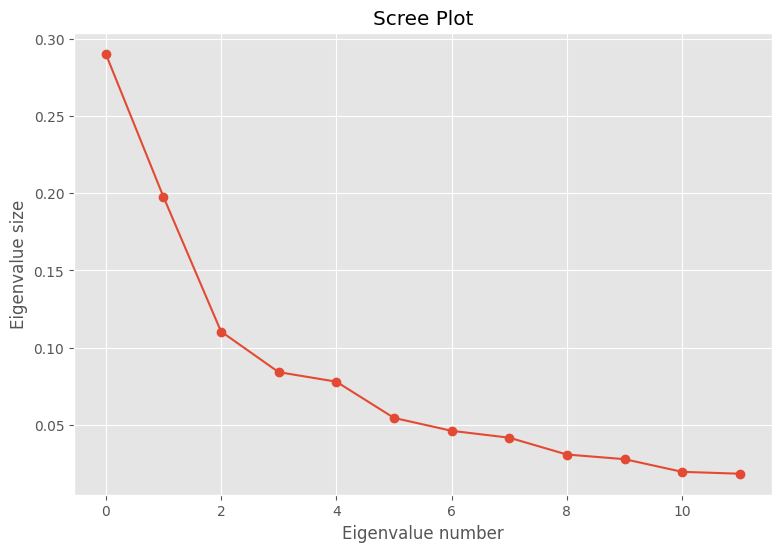

In [15]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.plot(pca_scree.explained_variance_ratio_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

In [16]:
pca = PCA(n_components = 4, svd_solver='full',)
pca.fit(df)
reduced = pca.transform(df)
loadings = pd.DataFrame(pca.components_.T)

# Paper Plot

[Text(0.5, 1.0, 'Loadings oblique_spl')]

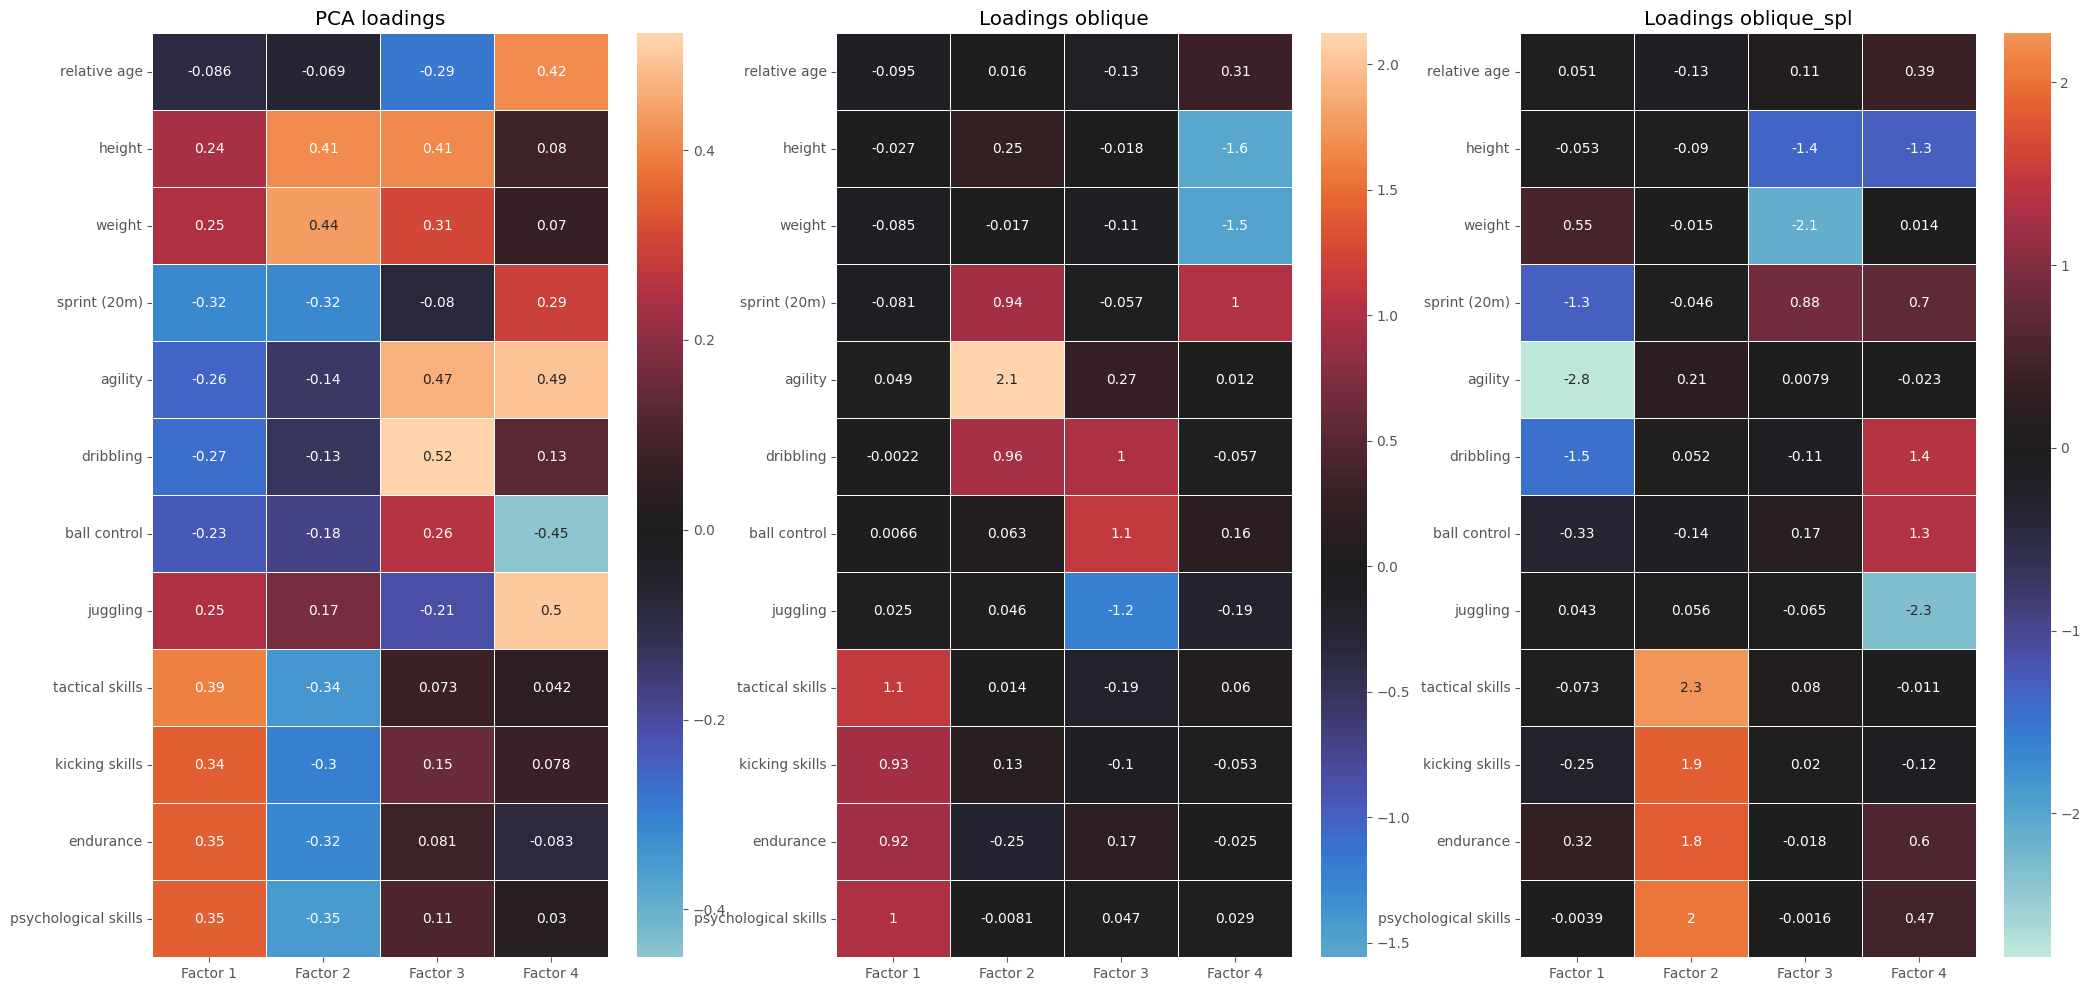

In [17]:
fig, axs = plt.subplots(1,3, figsize=(25,12))
sns.heatmap(ax=axs[0], data=loadings, annot=True, linewidths=0.5, vmin=loadings.min().min(), vmax=loadings.max().max(), center=0,xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=X_names).set(title='PCA loadings')
sns.heatmap(ax=axs[1], data=rot_loadings_iwave[:,[3,0,2,1]], annot=True, linewidths=0.5, vmin=rot_loadings_iwave.min(), vmax=rot_loadings_iwave.max(), center=0, xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=X_names).set(title='Loadings oblique')
sns.heatmap(ax=axs[2], data=rot_loadings_niwave[:,[3,0,1,2,]], annot=True, linewidths=0.5, vmin=rot_loadings_niwave.min(), vmax=rot_loadings_niwave.max(), center=0, xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=X_names).set(title='Loadings oblique_spl')

[Text(0.5, 1.0, 'Nonlinear loadings')]

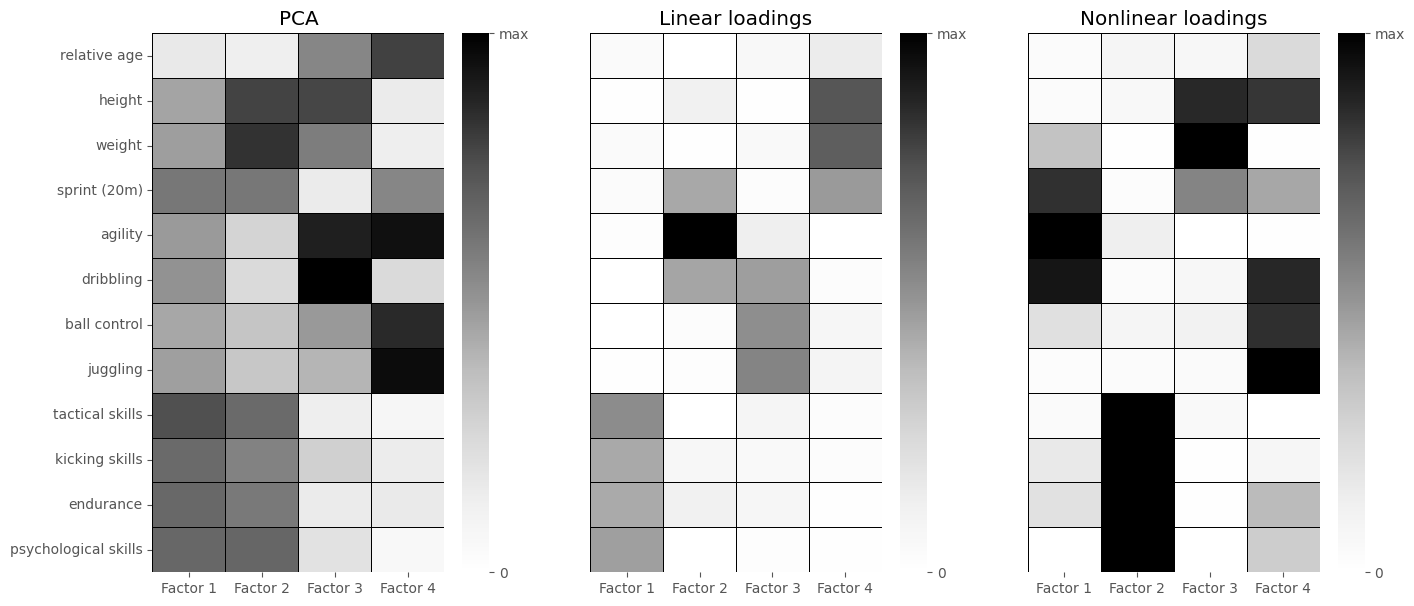

In [18]:
fig, axs = plt.subplots(1,3, figsize=(16,7), frameon=True)
sns.heatmap(ax=axs[0], data=abs(loadings), annot=False, linewidths=0.5, linecolor='black', vmin=0, center=loadings.max().max()/2, vmax=loadings.max().max(),xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=X_names, cmap = plt.cm.Greys, cbar=True, cbar_kws={'format': matplotlib.ticker.FixedFormatter(['0','max']),"ticks":[0,loadings.max().max()],}).set(title='PCA')
sns.heatmap(ax=axs[1], data=abs(rot_loadings_iwave[:,[3,0,2,1]]), annot=False, linewidths=0.5, linecolor='black', vmin=0, center=rot_loadings_iwave.max()/2, vmax=rot_loadings_iwave.max(), xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=False, cmap = plt.cm.Greys, cbar=True, cbar_kws={'format': matplotlib.ticker.FixedFormatter(['0','max']),"ticks":[0,rot_loadings_iwave.max()],}).set(title='Linear loadings')
sns.heatmap(ax=axs[2], data=abs(rot_loadings_niwave[:,[3,0,1,2,]]), annot=False, linewidths=0.5, linecolor='black', vmin=0, center=(rot_loadings_niwave.max()-0.7)/2,vmax=rot_loadings_niwave.max()-0.7, xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=False, cmap = plt.cm.Greys, cbar_kws={'format': matplotlib.ticker.FixedFormatter(['0','max']),"ticks":[0,rot_loadings_niwave.max()-0.7],}).set(title='Nonlinear loadings')

<Axes: >

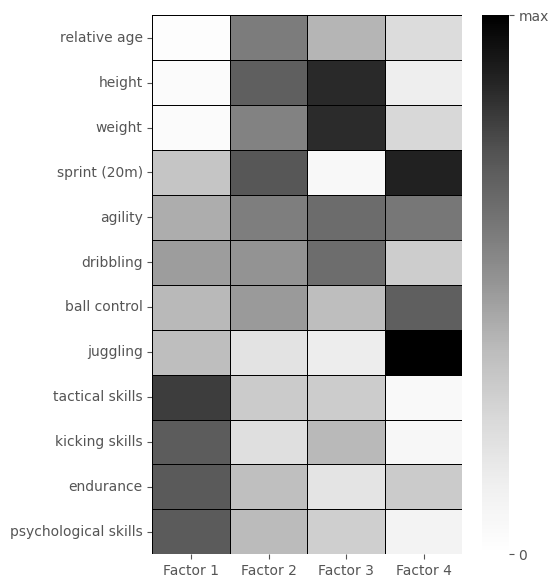

In [43]:
# PCA
plt.rcParams['figure.figsize'] = (5, 7)
sns.heatmap(data=abs(loadings), annot=False, linewidths=0.5, linecolor='black', vmin=0, center=loadings.max().max()/2, vmax=loadings.max().max(),xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=X_names, cmap = plt.cm.Greys, cbar=True, cbar_kws={'format': matplotlib.ticker.FixedFormatter(['0','max']),"ticks":[0,loadings.max().max()],})#.set(title='PCA loadings')

<Axes: >

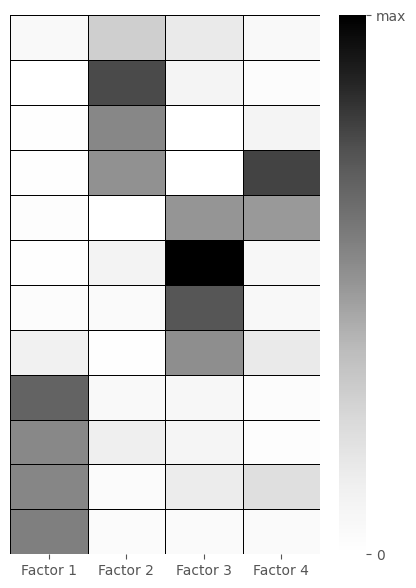

In [44]:
# linear
sns.heatmap(data=abs(rot_loadings_iwave[:,[3,0,2,1]]), annot=False, linewidths=0.5, linecolor='black', vmin=0, center=rot_loadings_iwave.max()/2, vmax=rot_loadings_iwave.max(), xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=False, cmap = plt.cm.Greys, cbar=True, cbar_kws={'format': matplotlib.ticker.FixedFormatter(['0','max']),"ticks":[0,rot_loadings_iwave.max()],})

<Axes: >

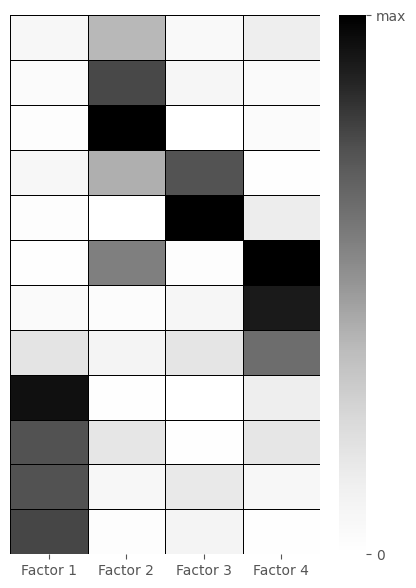

In [45]:
# non-linear
sns.heatmap(data=abs(rot_loadings_niwave[:,[3,0,1,2,]]), annot=False, linewidths=0.5, linecolor='black', vmin=0, center=(rot_loadings_niwave.max()-0.7)/2,vmax=rot_loadings_niwave.max()-0.7, xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=False, cmap = plt.cm.Greys, cbar_kws={'format': matplotlib.ticker.FixedFormatter(['0','max']),"ticks":[0,rot_loadings_niwave.max()-0.7],})

## Table

In [46]:
rot_load_table = torch.clone(rot_loadings_iwave)
rot_load_table_spl = torch.clone(rot_loadings_niwave)

loadings_table = loadings.copy()
loadings_table['variable'] = X_names
loadings_table.set_index('variable', inplace=True)
loadings_table.columns = ['fact. 1', 'fact. 2', 'fact. 3', 'fact. 4']

loadings_table[['iwave fact. 1', 'iwave fact. 2', 'iwave fact. 3', 'iwave fact. 4']] = rot_loadings_iwave[:,[3,0,2,1]]
loadings_table[['niwave fact. 1', 'niwave fact. 2', 'niwave fact. 3', 'niwave fact. 4']] = rot_loadings_niwave[:,[3,0,1,2,]]

loadings_table = round(loadings_table,2)
cut_percent = 0.1
pca_cut = cut_percent*loadings.max().max()
iwave_cut = np.asarray(cut_percent*rot_loadings_iwave.max())
niwave_cut = np.asarray(cut_percent*(rot_loadings_niwave.max()-0.7))
# pca
loadings_table.loc[np.abs(loadings_table['fact. 1']) < pca_cut, 'fact. 1'] = '.'
loadings_table.loc[np.abs(loadings_table['fact. 2']) < pca_cut, 'fact. 2'] = '.'
loadings_table.loc[np.abs(loadings_table['fact. 3']) < pca_cut, 'fact. 3'] = '.'
loadings_table.loc[np.abs(loadings_table['fact. 4']) < pca_cut, 'fact. 4'] = '.'
# iwave
loadings_table.loc[np.abs(loadings_table['iwave fact. 1']) < iwave_cut, 'iwave fact. 1'] = '.'
loadings_table.loc[np.abs(loadings_table['iwave fact. 2']) < iwave_cut, 'iwave fact. 2'] = '.'
loadings_table.loc[np.abs(loadings_table['iwave fact. 3']) < iwave_cut, 'iwave fact. 3'] = '.'
loadings_table.loc[np.abs(loadings_table['iwave fact. 4']) < iwave_cut, 'iwave fact. 4'] = '.'
# niwave
loadings_table.loc[np.abs(loadings_table['niwave fact. 1']) < niwave_cut, 'niwave fact. 1'] = '.'
loadings_table.loc[np.abs(loadings_table['niwave fact. 2']) < niwave_cut, 'niwave fact. 2'] = '.'
loadings_table.loc[np.abs(loadings_table['niwave fact. 3']) < niwave_cut, 'niwave fact. 3'] = '.'
loadings_table.loc[np.abs(loadings_table['niwave fact. 4']) < niwave_cut, 'niwave fact. 4'] = '.'

C:\Users\eduar\AppData\Local\Temp\ipykernel_29080\4227515965.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  loadings_table.loc[np.abs(loadings_table['fact. 1']) < pca_cut, 'fact. 1'] = '.'
C:\Users\eduar\AppData\Local\Temp\ipykernel_29080\4227515965.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  loadings_table.loc[np.abs(loadings_table['fact. 2']) < pca_cut, 'fact. 2'] = '.'
C:\Users\eduar\AppData\Local\Temp\ipykernel_29080\4227515965.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '.' has dtype incompatible with float64, please explicitly c

In [47]:
print(round(loadings_table,2).to_latex(escape=True, index=True, index_names=False, column_format='lrrrrrrrrrrrr', ))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & fact. 1 & fact. 2 & fact. 3 & fact. 4 & iwave fact. 1 & iwave fact. 2 & iwave fact. 3 & iwave fact. 4 & niwave fact. 1 & niwave fact. 2 & niwave fact. 3 & niwave fact. 4 \\
\midrule
relative age & . & 0.340000 & -0.230000 & -0.130000 & . & -0.440000 & 0.230000 & . & . & -0.680000 & . & 0.240000 \\
height & . & -0.400000 & 0.500000 & -0.080000 & . & 1.150000 & . & . & . & 1.350000 & . & . \\
weight & . & -0.330000 & 0.490000 & 0.150000 & . & 0.820000 & . & . & . & 2.250000 & . & . \\
sprint (20m) & -0.200000 & 0.420000 & . & 0.510000 & . & -0.770000 & . & 1.180000 & . & -0.730000 & 1.300000 & . \\
agility & -0.250000 & 0.340000 & 0.380000 & 0.350000 & . & . & 0.750000 & 0.730000 & . & . & 2.160000 & 0.250000 \\
dribbling & -0.280000 & 0.290000 & 0.370000 & -0.170000 & . & 0.150000 & 1.490000 & . & . & 1.010000 & . & 2.440000 \\
ball control & -0.220000 & 0.280000 & 0.210000 & -0.400000 & . & . & 1.090000 & . & . & . & . & 1.590000 \\
juggling &

# Prediction and MSE
As idea for an evaluation, we will estimate the expected latent values and perform the latent regression. We will use the unrotated loadings matrices (so we don't have to rotate the scores) and note that the results are also valid for the orthogonal rotation.
We calculate the regression by
$Bz+a$, where the intercept $a$ is zero.

In [179]:
scores = model.scores(Y_test, mc_samples=50, iw_samples=50)
scores_spl = model_spl.scores(Y_test, mc_samples=50, iw_samples=50)
scores = np.asarray(scores)
scores_spl = np.asarray(scores_spl)

In [180]:
res = np.matmul(loadings_array,scores.transpose())
res_spl = np.matmul(loadings_array_spl,scores_spl.transpose())

In [181]:
mse = np.square(res.transpose()-df_test).mean()
mse_spl = np.square(res_spl.transpose()-df_test).mean()
print(mse, mse_spl)

0.4017754074654846 0.4569875400536469
